Loading the dataset
At the moment we need to load the annotations directly from the database. We can replace this code with loading the csv file once the challenge is released

In [1]:
import numpy as np
import pandas as pd
from hcai_datasets.hcai_nova_dynamic.nova_db_handler import NovaDBHandler
from matplotlib.backends.backend_pdf import PdfPages

# Database Config file
db_cfg_path = '../../.configs/nova/nova_db.cfg'

# Sets
sessions_test = [f'recording{i:02d}' for i in range(1,7)]
sessions_train = [f'recording{i:02d}' for i in range(7,29)]

# Annotators
annotators = ['liechtensteinaugust','reineckermarcleon', 'fabianmaurer']

# Roles
roles = ['subjectPos1', 'subjectPos2', 'subjectPos3', 'subjectPos4']

# Schemes
scheme_consensus = 'backchannel_consensuality'
scheme_nonverbal = 'backchannel_nonverbal'
scheme_paraverbal = 'backchannel_paraverbal'
scheme_verbal = 'backchannel_verbal'

# Database handler
db_handler = NovaDBHandler(db_cfg_path)

# Annos
consensus = {}
nonverbal = {}
paraverbal = {}
verbal = {}


# Loading
for s in sessions_test + sessions_train:
    for r in roles:
        for a in annotators:
            print(f'Loading anno {s} - {r} - {a}')
            consensus[(s, r, a)] = db_handler.get_annos(dataset='mpiiemo', scheme=scheme_consensus, session=s,annotator=a,roles=r)
            nonverbal[(s, r, a)] = db_handler.get_annos(dataset='mpiiemo', scheme=scheme_nonverbal, session=s,annotator=a,roles=r)
            paraverbal[(s, r, a)] = db_handler.get_annos(dataset='mpiiemo', scheme=scheme_paraverbal, session=s,annotator=a,roles=r)
            verbal[(s, r, a)] = db_handler.get_annos(dataset='mpiiemo', scheme=scheme_verbal, session=s,annotator=a,roles=r)

Loaded config from ../../.configs/nova/nova_db.cfg:
---------------------
DB
	ip : 137.250.171.233
	port : 37317
	user : schildom
---------------------
Loading anno recording01 - subjectPos1 - liechtensteinaugust
Loading anno recording01 - subjectPos1 - reineckermarcleon
No annotions found for 
	-annotator: reineckermarcleon
	-scheme: backchannel_nonverbal
	-session: recording01
	-role: subjectPos1
No annotions found for 
	-annotator: reineckermarcleon
	-scheme: backchannel_paraverbal
	-session: recording01
	-role: subjectPos1
No annotions found for 
	-annotator: reineckermarcleon
	-scheme: backchannel_verbal
	-session: recording01
	-role: subjectPos1
Loading anno recording01 - subjectPos1 - fabianmaurer
No annotions found for 
	-annotator: fabianmaurer
	-scheme: backchannel_nonverbal
	-session: recording01
	-role: subjectPos1
No annotions found for 
	-annotator: fabianmaurer
	-scheme: backchannel_paraverbal
	-session: recording01
	-role: subjectPos1
No annotions found for 
	-annotator

In [2]:
# 0: consensus, 1: nonverbal, 2: paraverbal, 3: verbal
data_header = ['consensus', 'nonverbal', 'paraverbal', 'verbal']

# Dropping empty annos and convert rest to pandas dataframes
annos = [
    {key:pd.DataFrame(val) for key, val in consensus.items() if val != []},
    {key:pd.DataFrame(val) for key, val in nonverbal.items() if val != []},
    {key:pd.DataFrame(val) for key, val in paraverbal.items() if val != []},
    {key:pd.DataFrame(val) for key, val in verbal.items() if val != []}
]

# Add Partition to index
annos = [ {(('Train+Val',)+key if key[0] in sessions_train else ('Test',) + key) : val for key, val in x.items() } for x in annos]


In [3]:
def df_for_scheme(annos):
    df = pd.concat(annos)
    df = df.drop(columns=['conf', 'meta'])
    df.index.names = ['set', 'session', 'subject', 'annotator', 'id']
    df['dur'] = df['to'] - df['from']
    df = df.rename(columns={'id':'label'})
    return df

annos_stats = {n : df_for_scheme(annos[i]) for i,n in enumerate(data_header)}

# Map consensus label id to float value
annos_stats['consensus']['label'] = annos_stats['consensus']['label'].astype(float).replace(
    [0,1,2,3,4,5,6,7,8,9],
    [-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,np.nan]
)

print(annos_stats)
print('Annos have been generated. Read for analysis')

{'consensus':                                                              from       to  \
set       session     subject     annotator           id                     
Test      recording01 subjectPos1 liechtensteinaugust 0      6.68     8.40   
                                                      1     15.96    17.60   
                                                      2     20.68    22.76   
                                                      3     27.48    29.44   
                                                      4     31.12    33.28   
...                                                           ...      ...   
Train+Val recording28 subjectPos4 fabianmaurer        35  1164.56  1165.24   
                                                      36  1166.36  1167.64   
                                                      37  1173.68  1175.48   
                                                      38  1180.56  1181.56   
                                                  

Since there is a bug in the original annotations where multiple consensuality annotations are overlapping each other, we need to filter all annotations that are encapsulated in another larger annotation and remove them for the statistics.

In [50]:
import collections
df_consensus = annos_stats['consensus']
current_to = 0
overlap_idx = []
# Iterate over all consensus annotations
for idx, row in df_consensus.iterrows():
    if idx[-1] == 0:
        current_to = 0
    if row['to' ] > current_to:
        current_to = row['to']
    else:
        overlap_idx.append(idx)

print(f'Found {len(overlap_idx)} encapsulated agreement samples. First 20 are: ')
print(df_consensus.loc[overlap_idx[:20]])
annos_stats['consensus'] = annos_stats['consensus'].drop(overlap_idx)

Found 0 encapsulated agreement samples. First 20 are: 
Empty DataFrame
Columns: [from, to, label, dur, liechtensteinaugust, reineckermarcleon, fabianmaurer]
Index: []


Let`s generate some statistics...
We start with the general description of the dataframes

In [39]:
for k,v in annos_stats.items():
    print('----------------')
    print(k)
    print(v.describe())

----------------
consensus
               from            to         label           dur
count  21535.000000  21535.000000  20760.000000  21535.000000
mean     587.370296    589.052213      0.290185      1.681917
std      351.615382    351.676560      0.319006      1.500315
min        0.200000      1.600000     -1.000000      0.120000
25%      284.800000    285.840000      0.250000      0.800000
50%      571.520000    573.080000      0.250000      1.280000
75%      892.600000    894.120000      0.500000      2.040000
max     1301.440000   1301.880000      1.000000     25.080000
----------------
nonverbal
              from           to   label          dur
count  6064.000000  6064.000000  6064.0  6064.000000
mean    583.843555   585.709934     0.0     1.866379
std     350.792430   350.876424     0.0     1.531201
min       0.200000     1.640000     0.0     0.000000
25%     279.690000   281.430000     0.0     0.960000
50%     567.920000   569.860000     0.0     1.440000
75%     887.99000

## Backchannel Modalities ##

Generate statistics for backchannel modalities. First we plot the label count and the average duration per session per annotation track.
Also we plot a combination of verbal and paraverbal backchannels since those might not be clearly differentiated by the annotators.

In [40]:
from matplotlib import pyplot as plt

def plot_dist_for_modality_schemes(schemes, partition, title='', file_name=None,  font_size = 20):
    '''Plot Dtaframe statistics
    :param scheme: List of annotation schemes to plot
    :param partition: Test or Train
    :param stat: The column with the data t o plot
    :param title: Optional title for the plot
    :param file_name: Optional filename to save the plot under
    :param font_size: Optional font size to use in the plot
    '''

    # create new dataframe
    df_plot_label = pd.DataFrame()
    df_plot_duration = pd.DataFrame()

    for scheme in schemes:
        df_filtered = annos_stats[scheme].loc[partition,:,:,:]
        df_grouped = df_filtered.droplevel('id').groupby(level=['session'])
        stats = df_grouped.describe()
        df_plot_label[scheme] = stats['label']['count']
        df_plot_duration[scheme] = stats['dur']['mean']

    # plotting
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15,15))
    df_plot_label.rename(lambda x : x[-2:]).plot(kind='bar', ax=axes[0], fontsize=font_size, xlabel='')
    df_plot_duration.rename(lambda x : x[-2:]).plot(kind='bar', ax=axes[1], fontsize=font_size, xlabel='')

    axes[0].set_title(f'Label Count {title if title is not None else scheme}- {partition}' ,fontweight="bold", size=font_size)
    axes[1].set_title(f'Average Duration {title if title is not None else scheme}- {partition}' ,fontweight="bold", size=font_size)
    axes[1].set_xlabel('Session', fontsize=font_size)
    axes[0].set_ylabel('Count', fontsize=font_size)
    axes[1].set_ylabel('Duration', fontsize=font_size)
    axes[0].legend(prop = {'size' : 25}, bbox_to_anchor=(1, 1.03), loc='upper left')
    axes[1].get_legend().remove()
    plt.tight_layout()
    plt.subplots_adjust(left=0.125,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.35)


    # save as pdf
    if file_name:
        with PdfPages(file_name + '.pdf') as pdf:
            pdf.savefig(bbox_inches='tight')

    plt.show()

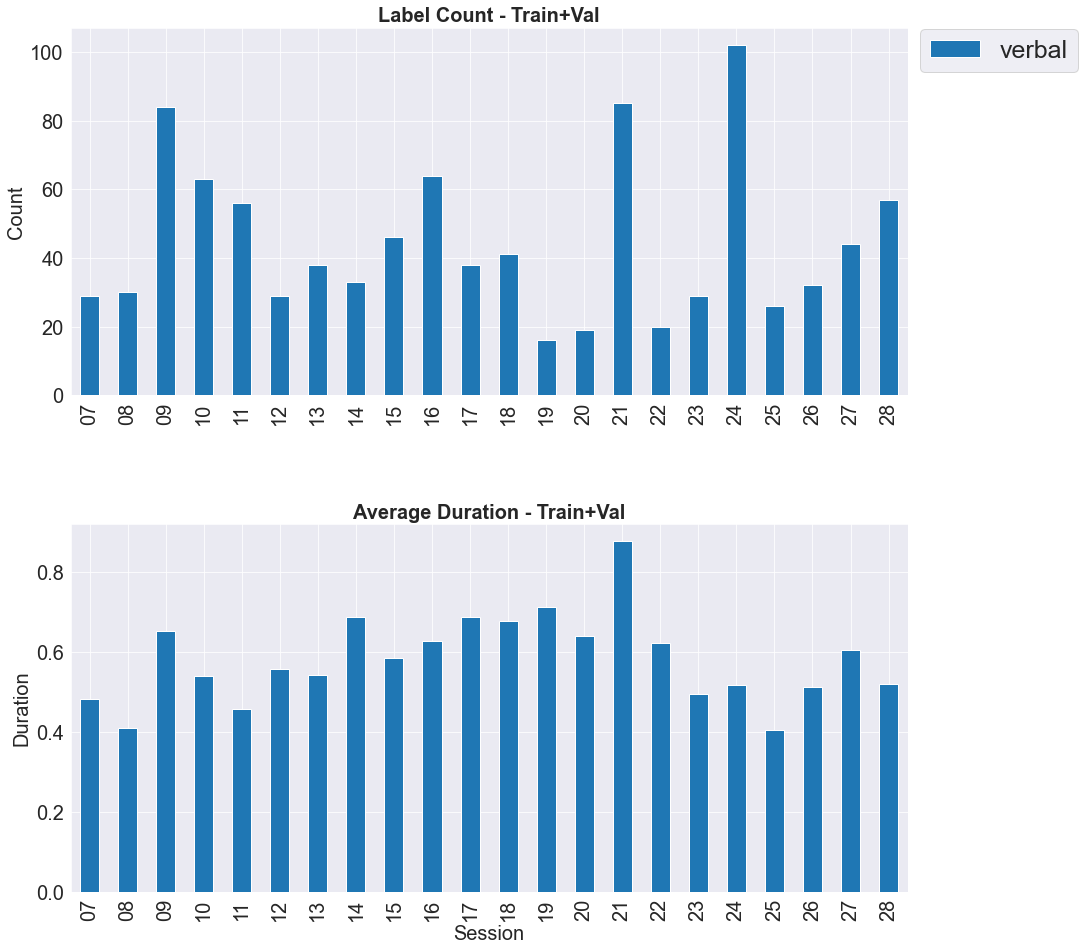

In [41]:
plot_dist_for_modality_schemes(['verbal'], 'Train+Val')

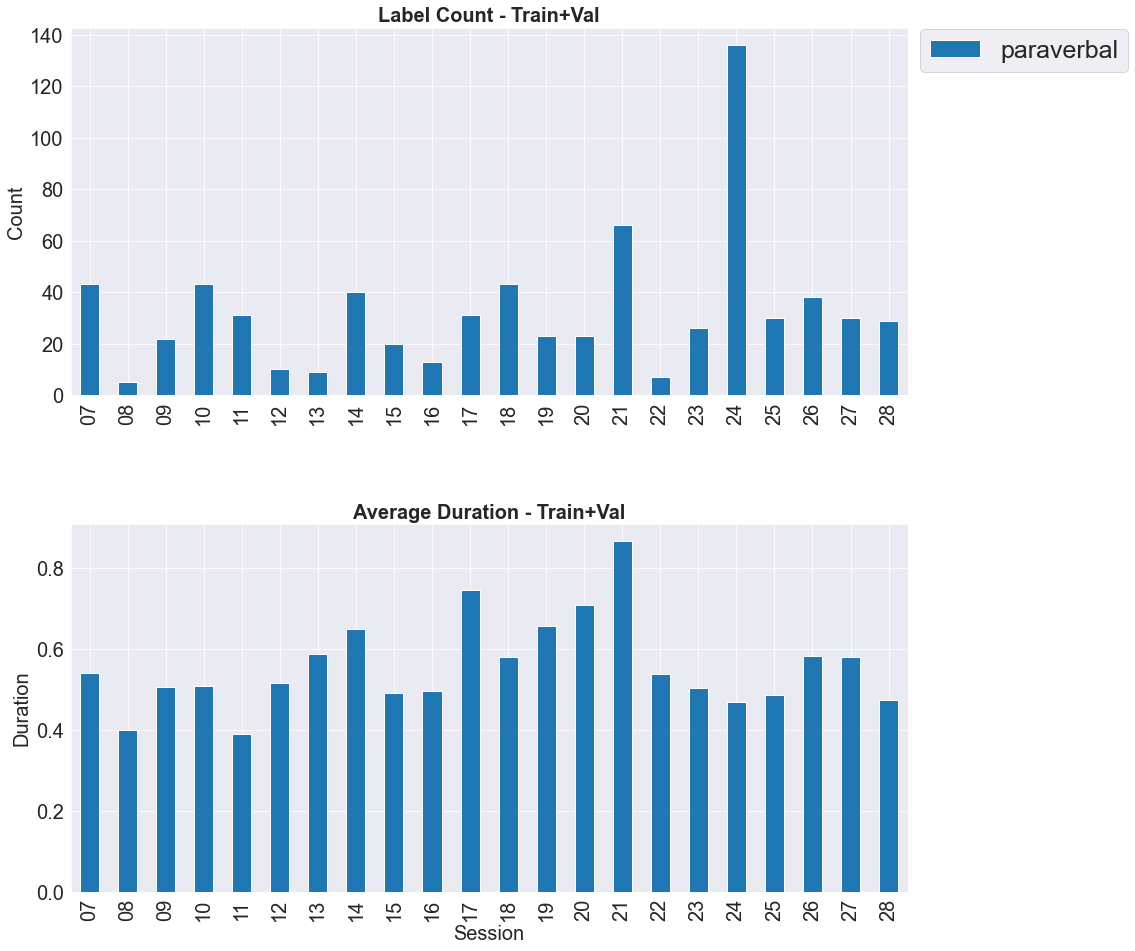

In [42]:
plot_dist_for_modality_schemes(['paraverbal'], 'Train+Val')

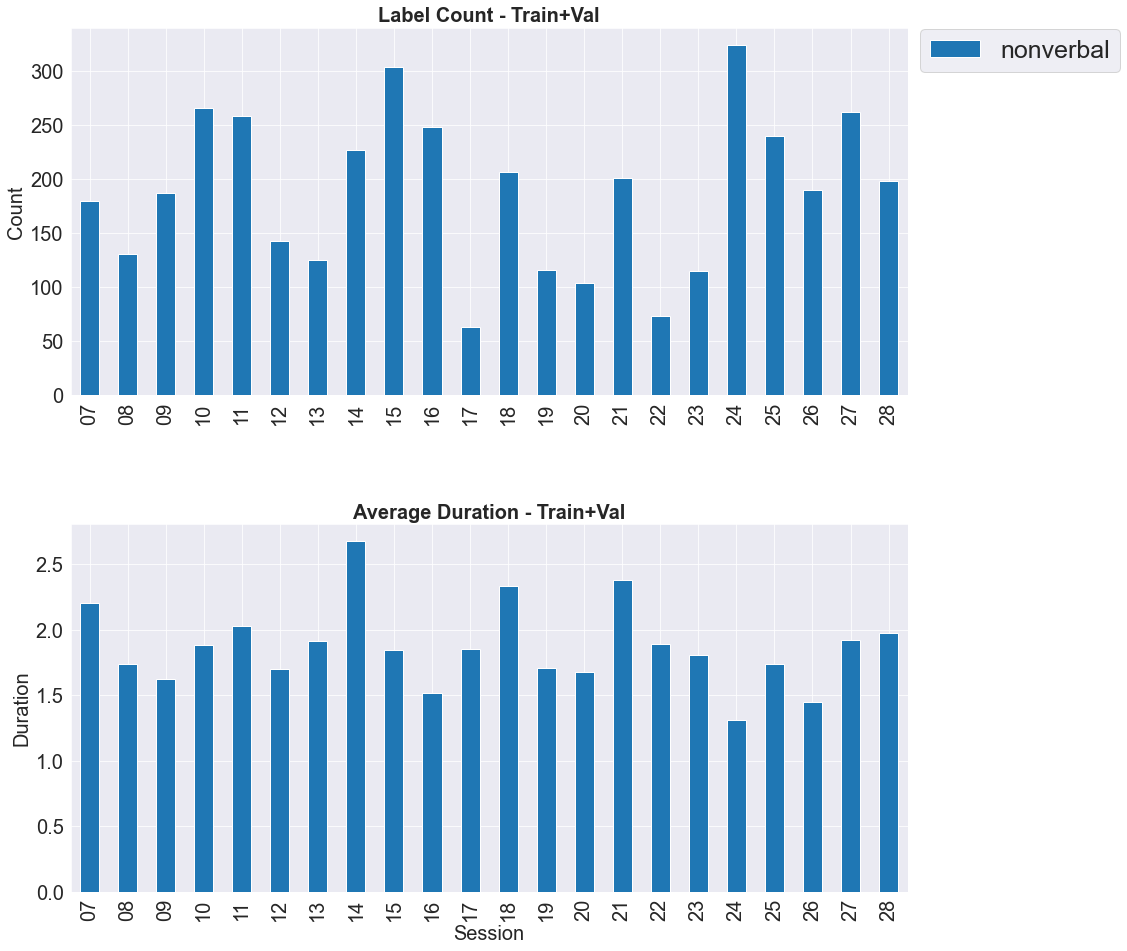

In [43]:
plot_dist_for_modality_schemes(['nonverbal'], 'Train+Val')

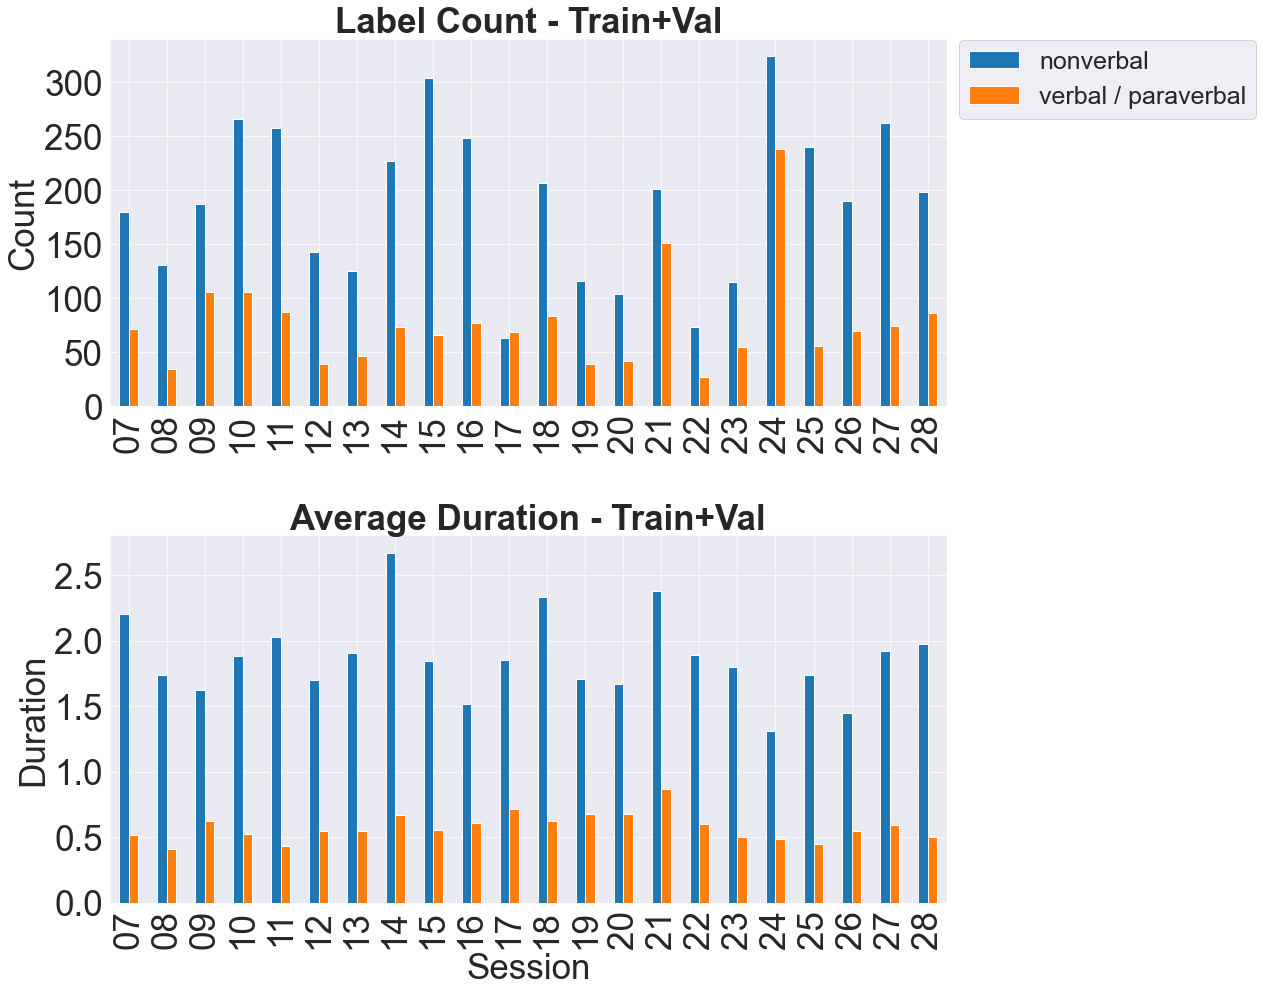

In [44]:
# combine nonverbal stats
annos_stats['verbal / paraverbal'] = pd.concat([annos_stats['paraverbal'], annos_stats['verbal']])
plot_dist_for_modality_schemes(['nonverbal', 'verbal / paraverbal'], 'Train+Val', title='', file_name='bc_stats', font_size=35)

## Backchannel Consensuality
In the following we first generate an overeview of the data

In [45]:
# Generate Stats for Train+Val
df_train = annos_stats['consensus'].loc['Train+Val',:,:,:]
df_train.droplevel('id').drop(columns=['from', 'to']).groupby(level=['session']).describe()

label                                                      dur  \
              count      mean       std   min   25%   50%   75%  max   count   
session                                                                        
recording07   592.0  0.256757  0.336318 -1.00  0.25  0.25  0.50  1.0   594.0   
recording08   426.0  0.162559  0.256929 -0.75  0.00  0.00  0.25  1.0   438.0   
recording09   715.0  0.228671  0.337569 -1.00  0.00  0.25  0.50  1.0   717.0   
recording10   933.0  0.219989  0.329658 -1.00  0.00  0.25  0.50  1.0   937.0   
recording11   826.0  0.262107  0.304519 -1.00  0.25  0.25  0.50  1.0   828.0   
recording12   469.0  0.233475  0.344553 -1.00  0.00  0.25  0.25  1.0   474.0   
recording13   419.0  0.158711  0.414872 -1.00  0.00  0.25  0.50  1.0   420.0   
recording14   744.0  0.336694  0.285432 -1.00  0.25  0.25  0.50  1.0   744.0   
recording15   954.0  0.301887  0.252597 -1.00  0.25  0.25  0.50  1.0   957.0   
recording16   781.0  0.281050  0.306834 -1.00  0.00  0.25  0.50  1.0   783.0   
recording17   317.0  0.264984  0.300929 -1.00  0.00  0.25  0.50  1.0   318.0   
recording18   668.0  0.312874  0.177372 -0.50  0.25  0.25  0.50  1.0   669.0   
recording19   384.0  0.335938  0.269968 -1.00  0.25  0.25  0.50  1.0   384.0   
recording20   388.0  0.151418  0.388935 -1.00  0.25  0.25  0.25  1.0   390.0   
recording21   774.0  0.336886  0.307242 -1.00  0.25  0.25  0.50  1.0   789.0   
recording22   231.0  0.341991  0.262577 -0.50  0.25  0.25  0.50  1.0   243.0   
recording23   406.0  0.407635  0.290429 -0.50  0.25  0.25  0.50  1.0   417.0   
recording24  1240.0  0.352621  0.299655 -1.00  0.25  0.25  0.50  1.0  1260.0   
recording25   702.0  0.272436  0.257786 -1.00  0.00  0.25  0.50  1.0   747.0   
recording26   627.0  0.181419  0.342482 -1.00  0.00  0.25  0.25  1.0   654.0   
recording27   801.0  0.351436  0.404190 -1.00  0.25  0.25  0.50  1.0   843.0   
recording28   658.0  0.327888  0.426386 -1.00  0.25  0.25  0.50  1.0   684.0   

                                                                
                 mean       std   min   25%   50%   75%    max  
session                                                         
recording07  2.080808  2.207332  0.24  0.96  1.40  2.48  20.56  
recording08  1.623836  1.947839  0.16  0.68  1.02  1.76  15.36  
recording09  1.436318  1.295005  0.20  0.72  1.16  1.76  12.68  
recording10  1.697545  1.418050  0.28  0.88  1.32  2.08  13.24  
recording11  1.929275  2.208155  0.16  0.92  1.42  2.00  25.08  
recording12  1.609367  1.310298  0.24  0.80  1.20  1.92   8.32  
recording13  1.770857  1.392065  0.24  0.88  1.36  2.17   8.84  
recording14  2.535968  1.944828  0.40  1.20  1.92  3.34  10.72  
recording15  1.802633  1.186915  0.20  1.08  1.56  2.16  12.48  
recording16  1.497165  1.136299  0.32  0.88  1.24  1.64  10.04  
recording17  1.429057  1.300982  0.32  0.68  1.08  1.60  10.08  
recording18  2.220987  1.688817  0.44  1.20  1.64  2.84  12.84  
recording19  1.616563  0.899163  0.40  1.00  1.44  2.00   6.28  
recording20  1.500615  0.819760  0.40  0.88  1.32  1.80   4.16  
recording21  2.064335  1.600346  0.48  1.08  1.60  2.60  14.20  
recording22  1.799506  1.417797  0.44  0.88  1.36  2.52   8.84  
recording23  1.589353  1.062938  0.20  0.92  1.32  2.04   5.84  
recording24  1.159810  0.840324  0.20  0.64  0.92  1.44   6.96  
recording25  1.721767  1.426894  0.20  0.92  1.32  2.00  12.28  
recording26  1.349541  1.086822  0.28  0.68  1.08  1.60   8.88  
recording27  1.851673  1.191629  0.28  0.92  1.60  2.44   6.76  
recording28  1.811754  1.448567  0.16  0.80  1.40  2.41   9.20

In [46]:
# Generate Stats for test
df_test = annos_stats['consensus'].loc['Test',:,:,:]
df_test.droplevel('id').drop(columns=['from', 'to']).groupby(level=['session']).describe()

label                                                     dur  \
              count      mean       std   min   25%   50%  75%  max   count   
session                                                                       
recording01  1038.0  0.314788  0.290820 -1.00  0.25  0.25  0.5  1.0  1095.0   
recording02   579.0  0.262522  0.309793 -1.00  0.00  0.25  0.5  1.0   657.0   
recording03  1529.0  0.323578  0.303743 -1.00  0.25  0.25  0.5  1.0  1632.0   
recording04  1617.0  0.300402  0.281458 -0.75  0.00  0.25  0.5  1.0  1776.0   
recording05   842.0  0.228325  0.372457 -1.00  0.00  0.25  0.5  1.0   939.0   
recording06  1100.0  0.369773  0.293286 -1.00  0.25  0.25  0.5  1.0  1146.0   

                                                                
                 mean       std   min   25%   50%   75%    max  
session                                                         
recording01  1.737753  1.387758  0.12  0.84  1.36  2.12   9.96  
recording02  1.125845  0.912327  0.16  0.56  0.88  1.40   8.40  
recording03  1.835368  1.725120  0.16  0.80  1.40  2.24  16.04  
recording04  1.403514  1.401702  0.16  0.48  0.98  1.80  12.48  
recording05  1.612396  1.900645  0.24  0.64  0.96  1.88  19.60  
recording06  1.583141  1.273941  0.20  0.68  1.26  2.04   7.96

To display the distribution of the consensuality labels we use a histogram plot.
Preliminarily we also rely on the annotations from August to create the plot since we do not have all annotations yet

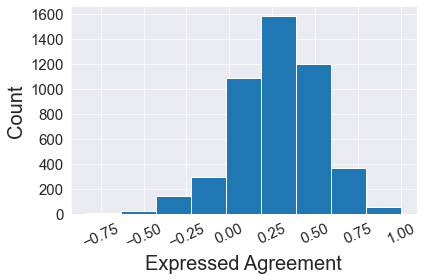

In [47]:
#plot
# Merge consensus annotations by averaging over annotators
df_train_merged = df_train.groupby(level=[0,1,3]).mean()
axes = df_train_merged['label'].plot.hist(bins=9)

plt.xticks(fontsize=15, rotation=25)
plt.yticks(fontsize=15, rotation=0)
plt.xlabel('Expressed Agreement', fontsize=20)
plt.ylabel('Count', fontsize=20)

# save as pdf
plt.tight_layout()
with PdfPages('bc_agreement_stats.pdf') as pdf:
    pdf.savefig()
plt.show()

Plotting the statistics for backchannel consensuality


In [48]:
tmp = df_train.groupby(level=['session', 'subject', 'id'])
for key, item in tmp:
    print(tmp.get_group(key), "\n\n")

                                                from     to  label   dur
session     subject     annotator           id                          
recording07 subjectPos2 liechtensteinaugust 0   22.6  23.16   0.25  0.56
                        reineckermarcleon   0   22.6  23.16   0.00  0.56
                        fabianmaurer        0   22.6  23.16   0.25  0.56 


                                                 from     to  label   dur
session     subject     annotator           id                           
recording07 subjectPos2 liechtensteinaugust 1   23.76  25.04    1.0  1.28
                        reineckermarcleon   1   23.76  25.04    0.0  1.28
                        fabianmaurer        1   23.76  25.04    0.5  1.28 


                                                 from     to  label   dur
session     subject     annotator           id                           
recording07 subjectPos2 liechtensteinaugust 2   28.52  30.36   0.00  1.84
                        reineckermarc

### Backchannel consesuality modality distribution

The following statistics are showing how much each modality contributed to the respective backchannel consensuality labels


In [57]:
df_consensus_all = annos_stats['consensus']

# dropping challenge samples that begin earlier than 10 seconds
df_consensus_filtered_start = df_consensus_all.drop(df_consensus_all[df_consensus_all['to'] < 10].index)

for i, df_consensus in enumerate([df_consensus_all, df_consensus_filtered_start]):
    print(f'Calculating consensus labels {i}')
    # Adding the consensus labels for each annotator as a separate column
    for annotator in df_consensus.index.unique(level='annotator'):
        df_consensus[annotator] = df_consensus[df_consensus.index.get_level_values('annotator') == annotator]['label']

    # Group dataframe by sessions, subject and label id
    grouped_consensus_all = df_consensus.groupby(level=['session', 'subject', 'id']).mean().sort_index()

    for modality in ['nonverbal', 'verbal', 'paraverbal']:
        # Get the annotated data for the respective modality
        df_modality =  annos_stats[modality].droplevel(['set', 'annotator']).sort_index().reset_index()

        # Iterate over all consensus annotations
        for idx, row in grouped_consensus_all.iterrows():
            # Get all matching entries for the given time interval
            matches = df_modality[
                (df_modality['session'] == idx[0]) &
                (df_modality['subject'] == idx[1]) &
                ((df_modality['from'] > row['from']) | (abs(df_modality['from'] - row['from']) < 1e-04)) &
               ((df_modality['to'] < row['to']) | (abs(df_modality['to'] - row['to']) < 1e-04))
            ]

             # Count if we have an overlapping label for the respective time interval in the consensus annotations
            count = len(matches)
            grouped_consensus_all.loc[idx, modality] = count
    if i == 0:
        grouped_consensus_all.to_csv('backchannel_agreement_modalities.csv')
    if i == 1:
        grouped_consensus_all.to_csv('backchannel_agreement_modalities_filtered_start_time.csv')

                                                             from       to  \
set       session     subject     annotator           id                     
Test      recording01 subjectPos1 liechtensteinaugust 0      6.68     8.40   
                                                      1     15.96    17.60   
                                                      2     20.68    22.76   
                                                      3     27.48    29.44   
                                                      4     31.12    33.28   
...                                                           ...      ...   
Train+Val recording28 subjectPos4 fabianmaurer        35  1164.56  1165.24   
                                                      36  1166.36  1167.64   
                                                      37  1173.68  1175.48   
                                                      38  1180.56  1181.56   
                                                      39  1185.4

### Multimediate 22 Baseline Paper

In this section we are plotting the following statistics for the multimediate baseline paper:
* Frequency of backchannels per modality
* Number of backchannels per participant
* Backchannel agreement per modality
* How is backchannel frequency distributed across speaking turns?

In [29]:
# Frequency of backchannels per modality
for modality in ['nonverbal', 'verbal', 'paraverbal']:
    print(f'Data description for {modality} backchannels \n {annos_stats[modality].describe()}')


Data description for nonverbal backchannels 
               from           to   label          dur
count  6064.000000  6064.000000  6064.0  6064.000000
mean    583.843555   585.709934     0.0     1.866379
std     350.792430   350.876424     0.0     1.531201
min       0.200000     1.640000     0.0     0.000000
25%     279.690000   281.430000     0.0     0.960000
50%     567.920000   569.860000     0.0     1.440000
75%     887.990000   889.620000     0.0     2.240000
max    1301.440000  1301.880000     0.0    25.080000
Data description for verbal backchannels 
               from           to   label          dur
count  1689.000000  1689.000000  1689.0  1689.000000
mean    601.525073   602.078257     0.0     0.553184
std     360.560151   360.565561     0.0     0.356171
min       1.400000     1.600000     0.0     0.000000
25%     288.400000   289.120000     0.0     0.360000
50%     575.000000   575.360000     0.0     0.480000
75%     907.240000   907.920000     0.0     0.640000
max    129

<AxesSubplot:xlabel='session,subject'>

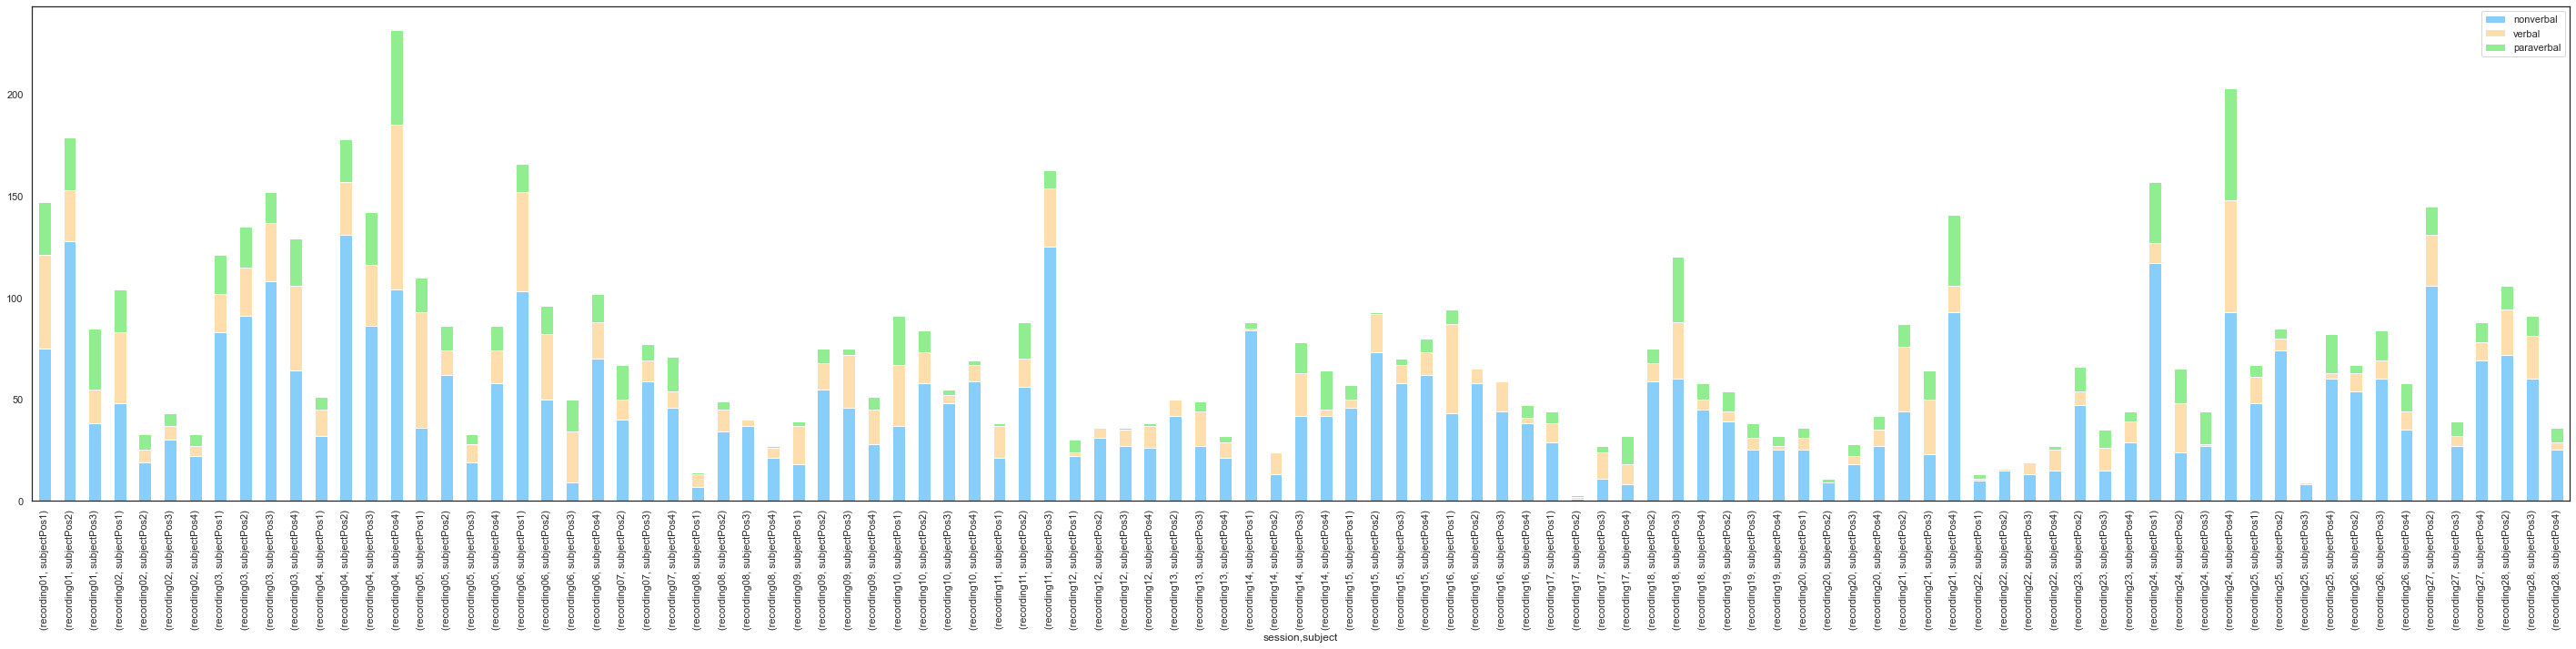

In [16]:
# Number of backchannels per participant
import seaborn as sns
sns.set()
sns.set_style("white")

num_backchannels = grouped_consensus_all.groupby(['session', 'subject']).sum()[['nonverbal', 'verbal', 'paraverbal']]
num_backchannels.plot(kind='bar', stacked=True, color=['lightskyblue', 'navajowhite', 'lightgreen'], figsize=(50,10))
